# Gradient-based multislice ptychography with Jax

The goal of this notebook is to present a simple, standalone example of gradient-based Ptychography with multislice, probe reconstruction and probe position optimisation.

The objective is *not* to make a package or robust library which can be used for arbitrary experimental data reconstruction, or be particularly optimised.

## What is Jax?

Jax (https://docs.jax.dev/en/latest/index.html) is a numpy-like library for computation, combining performance features (CPU, GPU, TPU and JIT-compilation) with automatic differentiation. It allows us to compute the numerical gradients of a function output with respect to its inputs, and then use this to optimise the inputs to achieve a certain outcome.

Jax can be used with a sister library Optax (https://optax.readthedocs.io/en/latest/index.html) which provides implementations of many optimisation algorithms written in Jax, such as ADAM or simple Stochastic Gradient Descent.

Jax and its sister libraries are similar to PyTorch or Tensorflow, but with less focus on deep learning and more focus on mathematics. Jax was originally created by Google to optimise computation on their custom TPU hardware.

In [1]:
%matplotlib inline

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".15"

import abtem
import ase
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
from itertools import chain, cycle, repeat
import tqdm.auto as tqdm
from abtem.multislice import FresnelPropagator as Propagator
from jax_multislice import get_abtem_transmit, Propagator as convolve2d, shift_kernel, energy2wavelength, get_frequencies, simple_fwhm

abtem.config.set({"device": "cpu"});


## Simulate data with abTEM

To make this notebook standalone, we will simulate our dataset here with abTEM. For speed this will only be quite a small-scale dataset.

### Structure + Potential

First build a structure to simulate and reconstruct. I stretch the `MoS2` unit cell slightly in the z-direction to give more propagation between the slices:

In [2]:
atoms = ase.build.mx2(vacuum=0.8)
atoms.set_cell(atoms.cell * np.asarray([1, 1, 4]), scale_atoms=True)
atoms = abtem.orthogonalize_cell(atoms)
atoms *= (3, 2, 1)  # this sets our horizontal extent, and by consequence our final diffraction pattern size

Choose a slice thickness to acheive one slice-per-layer:

In [3]:
base_sampling = 0.2
base_slice_thickness = 7

potential = abtem.Potential(
    atoms,
    sampling=base_sampling,
    slice_thickness=base_slice_thickness,
)
print(potential.shape)

(3, 48, 56)


As you can see the potential grid is quite small to allow this to run quickly in a notebook.

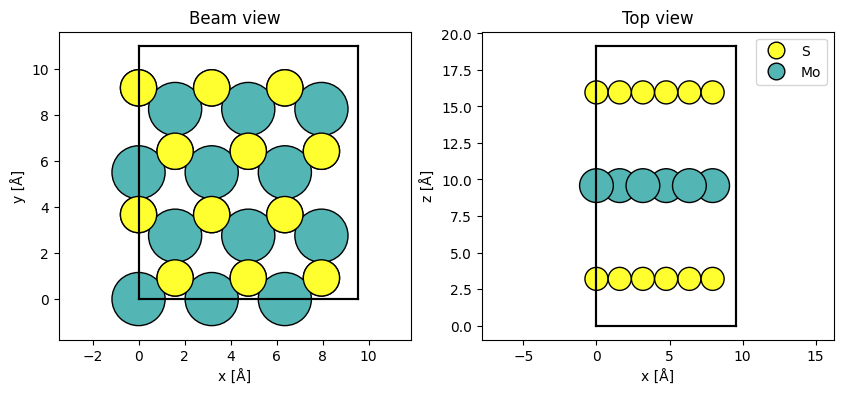

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Top view", legend=True);

We also compute the complex transmission function for the potential, this will be used to compare the reconstruction to the simulation:

In [5]:
energy = 200e3
transmit = get_abtem_transmit(potential, energy)

Visualise the different slices of the potential:

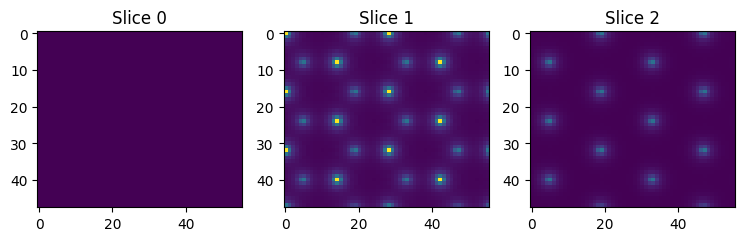

In [6]:
potential_array = potential.build(lazy=False).array
rows = int(np.floor(np.sqrt(len(potential_array))))
cols = int(np.ceil(np.sqrt(len(potential_array))))
if rows * cols < len(potential_array):
    cols += 1
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
vmin = potential_array.min()
vmax = potential_array.max()
for i, (p, s_ax) in enumerate(zip(potential_array, ax.ravel())):
    s_ax.imshow(p, vmin=vmin, vmax=vmax)
    s_ax.set_title(f"Slice {i}")

### Probe

We generate a probe with some strong aberrations, including the all-important defocus:

In [7]:
wavelength = energy2wavelength(energy)
semiangle_cutoff = 40.
defocus = 40.
astigmatism = 0.
astigmatism_angle = 0.
Cs = 1e2
coma = 5e2
coma_angle = 0.
trefoil = 1e2
trefoil_angle = np.pi / 7

W1212 11:19:05.587003 2175671 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1212 11:19:05.593944 2175262 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [8]:
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
    Cs=Cs,
    astigmatism=astigmatism,
    astigmatism_angle=astigmatism_angle,
    trefoil=trefoil,
    trefoil_angle=trefoil_angle,
    coma=coma,
    coma_angle=coma_angle,
)
probe.grid.match(potential)
probe.shape

(48, 56)

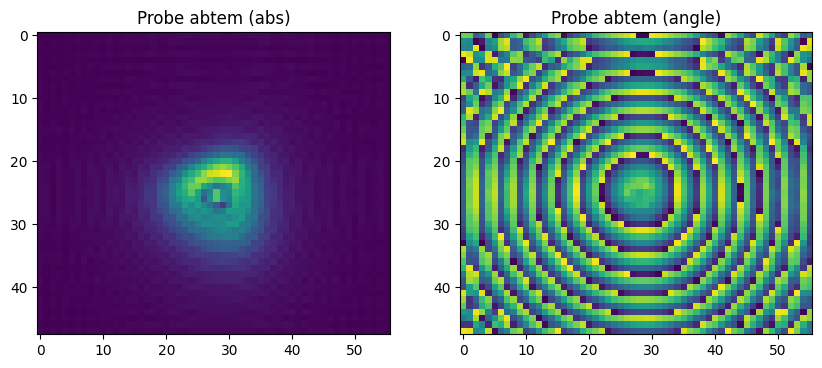

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(np.abs(probe.build(lazy=False).array))
ax1.set_title('Probe abtem (abs)');
ax2.imshow(np.angle(probe.build(lazy=False).array))
ax2.set_title('Probe abtem (angle)');

### Scan grid

As the potential is periodic we can have a scan grid that covers the whole object.

In principle as the probe is so defocused we could have a very large scan step as we have a lot of overlap in real-space.

In [10]:
grid_scan = abtem.GridScan(
    end=(1, 1),
    fractional=True,
    sampling=probe.aperture.nyquist_sampling * 3,
    potential=potential,
)
scan_positions = np.array(grid_scan.get_positions())
grid_scan.shape

(21, 24)

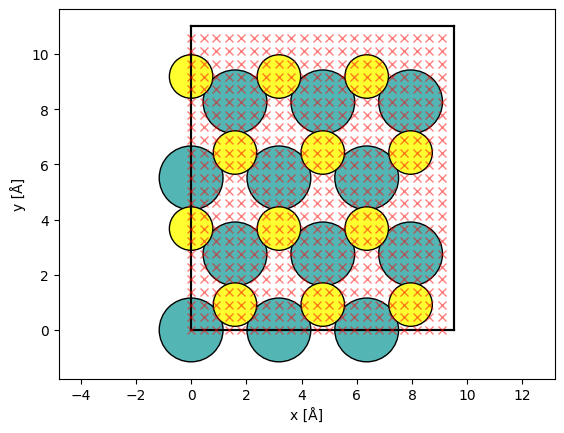

In [11]:
fig, ax = abtem.show_atoms(atoms)
scan_pos_flat = scan_positions.reshape(-1, 2)
ax.plot(scan_pos_flat[:, 0], scan_pos_flat[:, 1], 'rx', alpha=0.5);

We can estimate the overlap of adjacent probe positions in real space:

In [12]:
scan_step = (scan_pos_flat[1] - scan_pos_flat[0]).max()
probe_fwhm = simple_fwhm(np.abs(probe.build(lazy=False).array)[probe.gpts[0] // 2, :]) * probe.sampling[0]
print(f"Scan step of {scan_step:.1f} Å, probe FWHM of {probe_fwhm:.1f} Å, ratio {probe_fwhm / scan_step:.2f}")

Scan step of 0.5 Å, probe FWHM of 2.4 Å, ratio 5.20


Pre-generate all the probes for later use in iteration:

In [13]:
all_probes = probe.build(scan=grid_scan, lazy=False).array
all_probes_flat = all_probes.reshape(-1, *all_probes.shape[-2:])
all_probes_flat.dtype

dtype('complex64')

### Generate diffraction patterns

In [14]:
detector = abtem.PixelatedDetector(max_angle='full')
measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=detector,
)
abtem_patterns = measurements.compute().array
abtem_patterns_flat = abtem_patterns.reshape(-1, *abtem_patterns.shape[-2:])
abtem_patterns.shape

[########################################] | 100% Completed | 204.35 ms


(21, 24, 48, 56)

## Building a forward multislice model

One aspect of gradient-based multislice is that the reconstruction algorithm is "free", which is to say we just need to build a differentiable forward multislice model, and the implementation is capable of reversing it.

Forward multislice alternates between:

- Interaction: the probe or wavefront is multiplied with the object slice
- Propagation: the wavefront is convolved with a Fresnel propagation kernel for the inter-slice distance

Finally, the diffraction pattern is created from the FFT of the final wavefront, and its amplitude squared, i.e. the *intensity* we would see experimentally.

In [15]:
def simulate_pattern(object, probe, prop_kernel):
    wavefront = probe

    for i in range(object.shape[0]):
        wavefront = wavefront * object[i]
        wavefront = convolve2d(wavefront, prop_kernel)
    
    exit_wave = wavefront
    
    detector_wavefront = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(detector_wavefront.real)
        + jnp.square(detector_wavefront.imag)
    )
    return exit_wave, diffraction_pattern

simulate_pattern_jit = jax.jit(simulate_pattern)
simulate_pattern_vmap = jax.vmap(simulate_pattern_jit, in_axes=(None, 0, None))

We can check our own forward multislice model on abTEM's model at a given scan grid position, as you an see they are equivalent to numerical error:

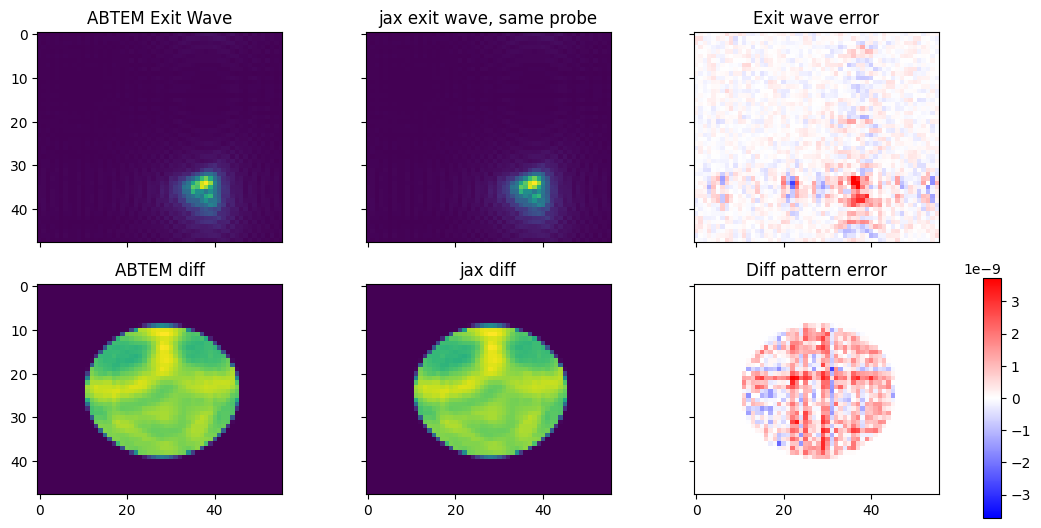

In [16]:
assert np.unique(potential.slice_thickness).size == 1
slice_thickness = potential.slice_thickness[0]

gx, gy = scan_positions.shape[:2]
idx_x, idx_y = 3 * gx // 4, 2 * gy  // 3
plot_scan = abtem.CustomScan(scan_positions[idx_x, idx_y], squeeze=True)

plot_exit_wave = probe.multislice(
    potential,
    scan=plot_scan,
    detectors=abtem.WavesDetector(),
    lazy=False,
).array
plot_probe = probe.build(scan=plot_scan).compute(progress_bar=False).array.squeeze()
assert (plot_probe == all_probes[idx_x, idx_y]).all()

probe_waves = probe._build_waves(probe)
jax_exit_wave, jax_pattern = simulate_pattern(
    transmit,
    all_probes[idx_x, idx_y],
    Propagator().get_array(probe_waves, float(slice_thickness)),
)

fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
ax = ax.ravel()
ax[0].imshow(np.abs(plot_exit_wave))
ax[0].set_title('ABTEM Exit Wave')
ax[1].imshow(np.abs(jax_exit_wave))
ax[1].set_title('jax exit wave, same probe')
exit_fn_diff = np.abs(plot_exit_wave) - np.abs(jax_exit_wave)
vmax = np.abs(exit_fn_diff).max()
ax[2].imshow(exit_fn_diff, cmap='bwr', vmax=vmax, vmin=-vmax)
ax[2].set_title('Exit wave error');

ax[3].imshow(abtem_patterns[idx_x, idx_y])
ax[3].set_title('ABTEM diff')
ax[4].imshow(jax_pattern)
ax[4].set_title('jax diff');
pattern_diff = abtem_patterns[idx_x, idx_y] - jax_pattern
vmax = np.abs(pattern_diff).max()
im = ax[5].imshow(pattern_diff, cmap='bwr', vmax=vmax, vmin=-vmax)
ax[5].set_title('Diff pattern error');
cbar_ax = fig.add_axes([0.925, 0.07, 0.015, 0.4])
fig.colorbar(im, cax=cbar_ax);

## Inverse Multislice, object-optimisation only

To fit an object function to the set of diffraction patterns, we define an error function (*loss* in ML-parlance). The absolute simplest form of this loss the mean-squared-error between the measured and reconstructed diffraction patterns.

Optax provides us this loss as a function `optax.l2_loss(predictions, targets)`.

The reconstruction process is to generate a set of `jax_patterns` with the current `object`, compute a scalar error, then use the gradient of this `loss` with respect to the `object` to do gradient descent, so modifying the `object` each iteration.

In [17]:
def loss(target_patterns, object, probes, prop_kernel):
    # Simulate the diffraction patterns for a set of probes on the current object estimate
    _, jax_patterns = simulate_pattern_vmap(object, probes, prop_kernel)
    return (
        optax.l2_loss(jax_patterns, target_patterns).mean()
    )

loss_jit = jax.jit(loss)

To reconstruct an object we need to choose our number of slices, create an inital guess and generate the other inputs to the forward model, notably all of the probes, and the Fresnel propagator.

In [18]:
num_slices_recon = 3
recon_obj_shape = (num_slices_recon, *transmit.shape[-2:])
opt_object = jnp.ones(recon_obj_shape, dtype=jnp.complex64)

# All the probes as a Jax array
all_probes_flat = jnp.asarray(all_probes_flat)

# Use the abTEM propagator, needs to match the slice thickness in the reconstruction
recon_slice_thickness = float(sum(potential.slice_thickness) / num_slices_recon)
prop_abtem = jnp.asarray(Propagator().get_array(probe_waves, recon_slice_thickness))

We can choose to optimise against abTEM's diffraction patterns or patterns generated with the forward model, as shown above these are equivalent:

In [19]:
transmit = jnp.asarray(transmit)
_, jax_patterns_flat = simulate_pattern_vmap(transmit, all_probes_flat, prop_abtem)
target_patterns = jax_patterns_flat
target_name = 'abtem'

Initialize the optimiser. Contrary to typical use of ADAM this problem can accept a very high initial learning rate.

This optimizer keeps track of the gradients of `loss/object`, so as to choose an appropriate step size when modifying `object`.

In [20]:
learning_rate = 5e1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_object)

The optimisation is run using randomised batches of diffraction patterns (`chunksize` patterns at a time), for a total of `num_epochs` passes over the whole dataset.

In [21]:
num_epochs = 3000  # number of passes through the dataset
chunksize = 256  # number of patterns used to compute an update step

Most of the code here is to do with plotting and randomising the sets of patterns we pass to the forward model. In reality it can be summarised as:

```python
for true_patterns in dataset:
    gradient = loss_gradient(true_patterns, object, probe, propagator)
    obj = obj - stepsize * gradient
```

In [22]:
num_patterns = len(target_patterns)
iteration_idxs = np.arange(num_patterns)
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)
chunks = chunks[:-1]  # skip the last chunk as it may be incomplete, which will add a periodic spike in the loss, not an issue as we are shuffling
assert len(chunks) > 0, "Chunksize is too large for this dataset"

num_iterations = len(chunks) * num_epochs
losses = np.full((num_iterations,), np.nan)

val_grad_fn = jax.value_and_grad(loss_jit, argnums=1)

iteration = 0
for epoch in (outer_pbar := tqdm.trange(num_epochs)):
    np.random.shuffle(iteration_idxs)
    for chunk in chunks:
        loss_val, grads = val_grad_fn(
            target_patterns[iteration_idxs[chunk]],
            opt_object,
            all_probes_flat[iteration_idxs[chunk]],
            prop_abtem,
        )
        # Conjugating the gradients is necessary in Jax, we are not sure why
        grads = jnp.conjugate(grads)
        updates, opt_state = optimizer.update(grads, opt_state)
        opt_object = optax.apply_updates(opt_object, updates)
        losses[iteration] = loss_val
        iteration += 1
    if (epoch % 10) == 0:
        outer_pbar.set_description(f"Loss {losses[max(0, iteration - 20):iteration].mean(): .3e}")

  0%|          | 0/3000 [00:00<?, ?it/s]

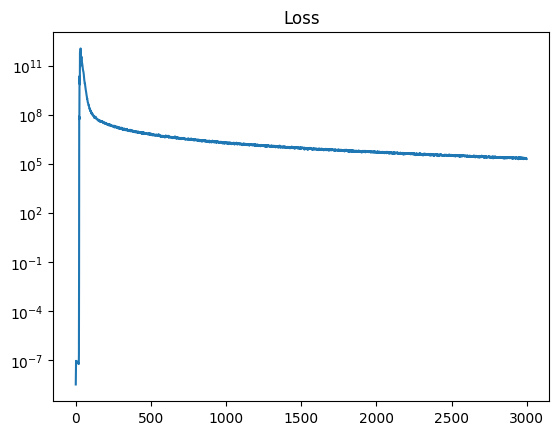

In [23]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("Loss");
ax.set_yscale("log")

Once done, we can compare the reconstructed object to the abTEM object used to generate the patterns:

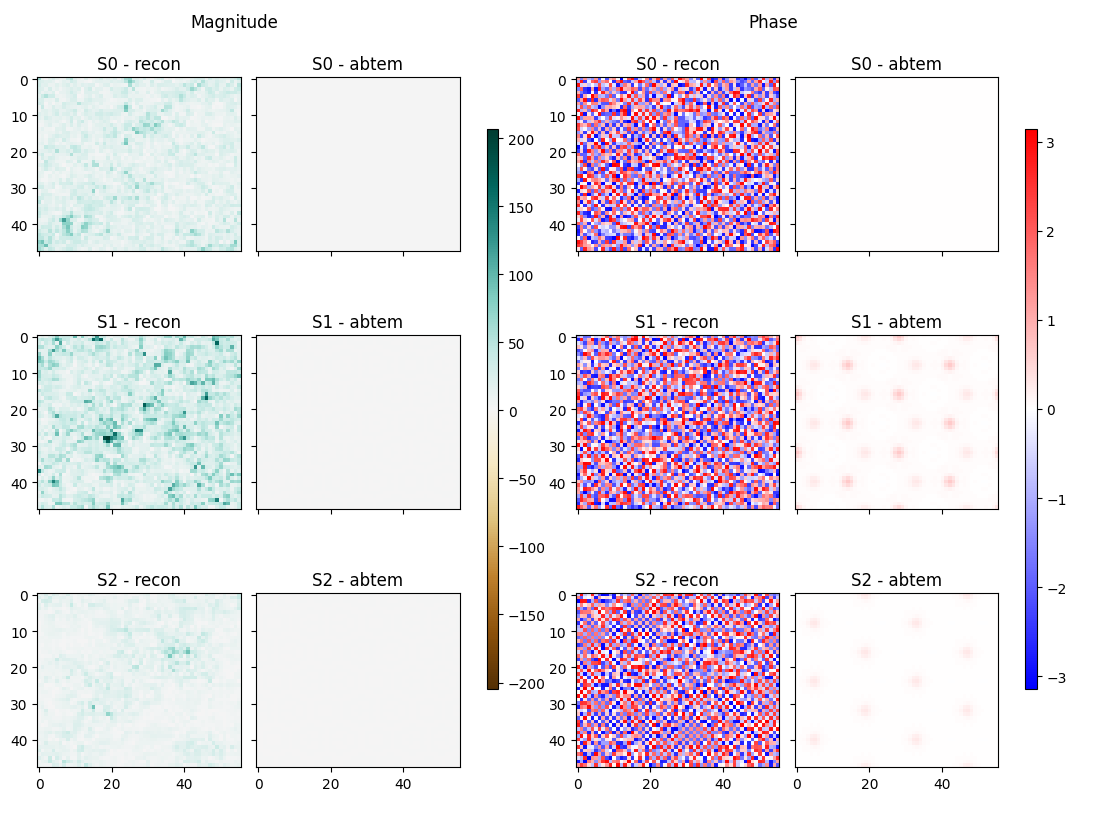

In [24]:
fig = plt.figure(layout="constrained", figsize=(11, 8))
subfigs = fig.subfigures(1, 3, wspace=0.22, width_ratios=[1, 1, 0.05])

axs = subfigs[0].subplots(num_slices_recon, 2, sharex=True, sharey=True)
a_max = max(np.abs((np.abs(opt_object) - 1)).max(), np.abs((np.abs(transmit) - 1)).max())
ang_max = max(np.abs(np.angle(opt_object)).max(), np.abs(np.angle(transmit)).max())


for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_object, transmit, axs)):
    im_abs = ax1.imshow(np.abs(recon_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.abs(abtem_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax2.set_title(f"S{i} - {target_name}")
subfigs[0].suptitle("Magnitude")
cbar_ax = subfigs[0].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[0].colorbar(im_abs, cax=cbar_ax)

num_slices_potential = transmit.shape[0]
axs = subfigs[1].subplots(num_slices_potential, 2, sharex=True, sharey=True)
for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_object, transmit, axs)):
    im_ang = ax1.imshow(np.angle(recon_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.angle(abtem_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax2.set_title(f"S{i} - {target_name}")
subfigs[1].suptitle("Phase");
cbar_ax = subfigs[1].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[1].colorbar(im_ang, cax=cbar_ax);

## Inverse multislice, probe reconstruction

We can use the exact same approach to optimise the probe function, the same `L2-loss` is a valid way to measure if the diffractions patterns match the target as the probe is modified.

We do need a modified forward model which can shift the probe array to the scan coordinates, rather than using pre-shifted probes. To do this we use Fourier image shifting to allow for sub-pixel precision.

In [25]:
def simulate_pattern_shifting(object, probe_fft, scan_position, prop_kernel, shift_frequencies):
    probe = jnp.fft.ifft2(
        probe_fft * shift_kernel(*scan_position, *shift_frequencies)
    )
    _, diffraction_pattern = simulate_pattern_jit(object, probe, prop_kernel)
    return diffraction_pattern, probe

simulate_pattern_shifting_jit = jax.vmap(
    jax.jit(simulate_pattern_shifting),
    in_axes=(None, None, 0, None, None),
)

The loss function now takes the current `object`, `probe`, and a set of matching `scan_positions` and `target_patterns` to optimise against. The function computes the diffraction patterns for these positions and *object+probe*, then reurns the loss.

In [26]:
def loss_with_probe(target_patterns, object, probe_fft, scan_positions, prop_kernel, shift_frequencies):
    jax_patterns, _ = simulate_pattern_shifting_jit(
        object,
        probe_fft,
        scan_positions,
        prop_kernel,
        shift_frequencies,
    )
    return (
        optax.l2_loss(jax_patterns, target_patterns).mean()
    )

loss_with_probe_jit = jax.jit(loss_with_probe)

We need an initial probe to optimise, so we use abTEM's `Probe` class to get an probe which contains the right semiconvergence angle and defocus, but no other aberrations.

In [27]:
initial_probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
)
initial_probe.grid.match(potential)
initial_probe_array = initial_probe.build((0., 0.), lazy=False).array

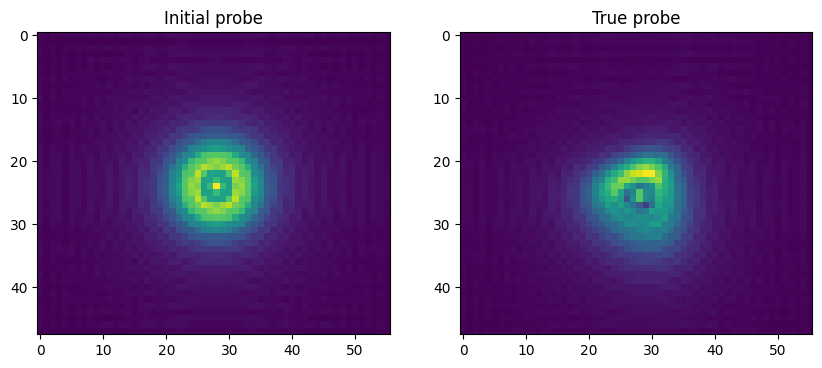

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(np.abs(np.fft.fftshift(initial_probe_array)))
ax1.set_title("Initial probe")
ax2.imshow(np.abs(np.fft.fftshift(all_probes_flat[0])))
ax2.set_title("True probe");

To shift the probe with the FFT method we also need the arrays of frequencies in FFT-space, this is done once to save computation.

In [29]:
shift_frequencies = get_frequencies(transmit.shape[-2:], potential.sampling)

TypeError: get_frequencies() missing 1 required positional argument: 'ps'

Probe optimizer, again an ADAM optimizer (standard).

In [ ]:
opt_probe_fft = jnp.fft.fft2(initial_probe_array)
probe_learning_rate = 1e-1
optimizer_probe = optax.adam(probe_learning_rate)
opt_state_probe = optimizer_probe.init(opt_probe_fft)

In [ ]:
chunksize = 256
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)

val_and_grad_probe = jax.value_and_grad(loss_with_probe_jit, argnums=2)

for epoch in (outer_pbar := tqdm.trange(1000)):
    np.random.shuffle(iteration_idxs)
    for chunk in chunks:
        loss_val, grads_probe = val_and_grad_probe(
            target_patterns[iteration_idxs[chunk]],
            transmit,
            opt_probe_fft,
            scan_pos_flat[iteration_idxs[chunk]],
            prop_abtem,
            shift_frequencies,
        )
        grads_probe = jnp.conjugate(grads_probe)
        updates_probe, opt_state_probe = optimizer_probe.update(grads_probe, opt_state_probe)
        opt_probe_fft = optax.apply_updates(opt_probe_fft, updates_probe)
        outer_pbar.set_description(f"Loss {loss_val: .3e}")

  0%|          | 0/1000 [00:00<?, ?it/s]

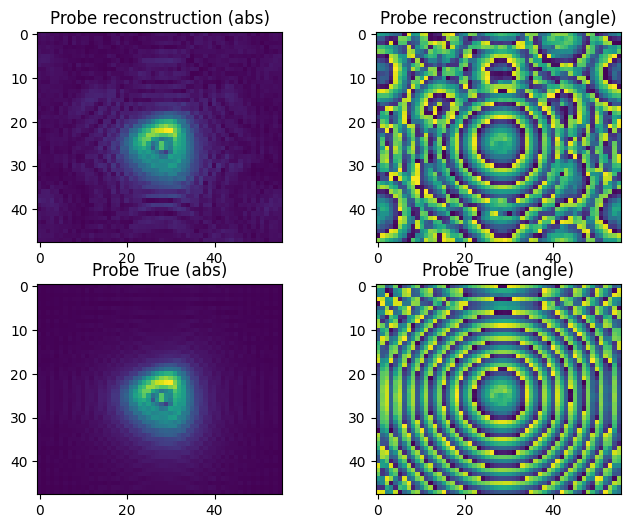

In [ ]:
probe_recon = jnp.fft.ifftshift(jnp.fft.ifft2(opt_probe_fft))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
ax1.imshow(np.abs(probe_recon))
ax1.set_title('Probe reconstruction (abs)');
ax2.imshow(np.angle(probe_recon))
ax2.set_title('Probe reconstruction (angle)');
ax3.imshow(np.abs(np.fft.fftshift(all_probes_flat[0])))
ax3.set_title('Probe True (abs)');
ax4.imshow(np.angle(np.fft.fftshift(all_probes_flat[0])))
ax4.set_title('Probe True (angle)');

## Inverse multislice, object + probe reconstruction

We can use the same loss function to optimise both probe and object simulatneously, with the caveat that the optimisation space is more complex so will be harder to converge on. As a minimum we can use a smaller stepsize (learning rate) to begin.

Create an initial guess and optimizer for the object and probe:

In [ ]:
initial_probe_array = initial_probe.build((0., 0.), lazy=False).array
opt_probe_fft = jnp.fft.fft2(initial_probe_array)
probe_learning_rate = 1e-2
optimizer_probe = optax.adam(probe_learning_rate)
opt_state_probe = optimizer_probe.init(opt_probe_fft)

In [ ]:
opt_object = jnp.ones(recon_obj_shape, dtype=jnp.complex64)
object_learning_rate = 1e0
optimizer_object = optax.adam(object_learning_rate)
opt_state_object = optimizer_object.init(opt_object)

This is the point where the optimisation process becomes slightly "artisanal", as we will find that simultaneously updatng object and probe, except with very small step sizes, causes the loss to diverge. Instead we can take an alternating approach, with a certain number of object iterations, then probe iterations, in a loop.

In [ ]:
total_iterations = 10_000
chunksize = 256
initial_object_iterations = 500
object_iterations = 40
probe_iterations = 5

training_schedule = chain(
    repeat("Object", initial_object_iterations),
    cycle(
        chain(
            repeat("Object", object_iterations),
            repeat("Probe", probe_iterations),
        )
    )
)
training_schedule_iter = iter(training_schedule)
losses = []

In [ ]:
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)

val_and_grad_objprobe = jax.value_and_grad(loss_with_probe_jit, argnums=(1, 2))

for epoch in (outer_pbar := tqdm.trange(total_iterations)):
    optimising = next(training_schedule_iter)
    np.random.shuffle(iteration_idxs)
    for batch_idx, chunk in enumerate(chunks):
        loss_val, (grads_object, grads_probe) = val_and_grad_objprobe(
            target_patterns[iteration_idxs[chunk]],
            opt_object,
            opt_probe_fft,
            scan_pos_flat[iteration_idxs[chunk]],
            prop_abtem,
            shift_frequencies,
        )
        if optimising == "Probe":
            grads_probe = jnp.conjugate(grads_probe)
            updates_probe, opt_state_probe = optimizer_probe.update(grads_probe, opt_state_probe)
            opt_probe_fft = optax.apply_updates(opt_probe_fft, updates_probe)
        else:
            grads_object = jnp.conjugate(grads_object)
            updates_object, opt_state_object = optimizer_object.update(grads_object, opt_state_object)
            opt_object = optax.apply_updates(opt_object, updates_object)
        outer_pbar.set_description(f"Loss {loss_val: .3e}, opt: {optimising}")
    losses.append(loss_val)

  0%|          | 0/10000 [00:00<?, ?it/s]

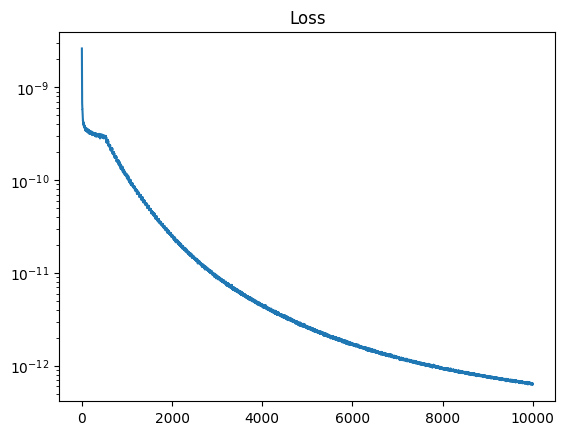

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title("Loss");
ax.set_yscale("log")

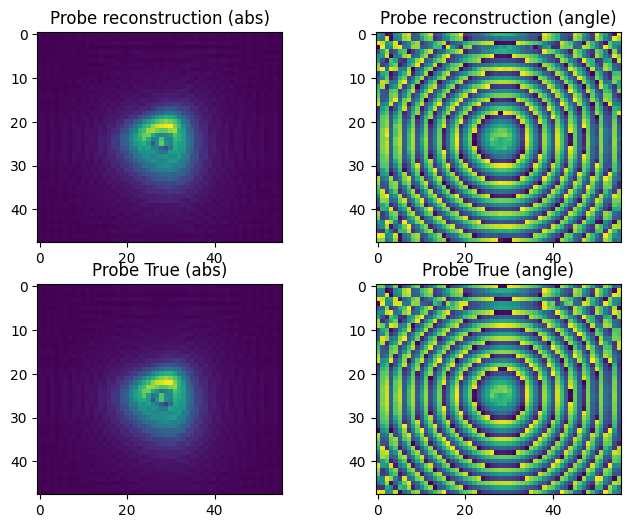

In [ ]:
probe_recon = jnp.fft.ifftshift(jnp.fft.ifft2(opt_probe_fft))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
ax1.imshow(np.abs(probe_recon))
ax1.set_title('Probe reconstruction (abs)');
ax2.imshow(np.angle(probe_recon))
ax2.set_title('Probe reconstruction (angle)');
ax3.imshow(np.abs(np.fft.fftshift(all_probes_flat[0])))
ax3.set_title('Probe True (abs)');
ax4.imshow(np.angle(np.fft.fftshift(all_probes_flat[0])))
ax4.set_title('Probe True (angle)');

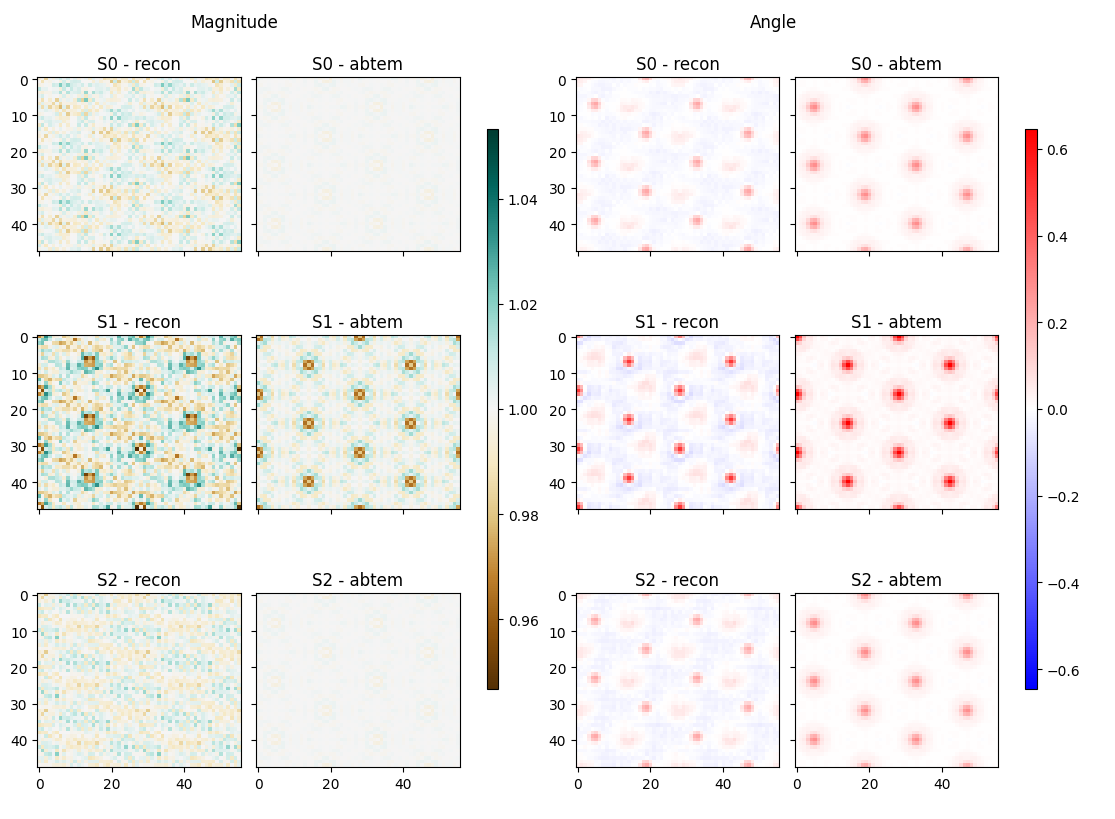

In [ ]:
fig = plt.figure(layout="constrained", figsize=(11, 8))
subfigs = fig.subfigures(1, 3, wspace=0.22, width_ratios=[1, 1, 0.05])

axs = subfigs[0].subplots(num_slices_recon, 2, sharex=True, sharey=True)
a_max = max(np.abs((np.abs(opt_object) - 1)).max(), np.abs((np.abs(transmit) - 1)).max())
ang_max = max(np.abs(np.angle(opt_object)).max(), np.abs(np.angle(transmit)).max())


for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_object, transmit, axs)):
    im_abs = ax1.imshow(np.abs(recon_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.abs(abtem_slice), vmin=1 - a_max, vmax=1 + a_max, cmap="BrBG")
    ax2.set_title(f"S{i} - {target_name}")
subfigs[0].suptitle("Magnitude")
cbar_ax = subfigs[0].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[0].colorbar(im_abs, cax=cbar_ax)

num_slices_potential = transmit.shape[0]
axs = subfigs[1].subplots(num_slices_potential, 2, sharex=True, sharey=True)
for i, (recon_slice, abtem_slice, (ax1, ax2)) in enumerate(zip(opt_object, transmit, axs)):
    im_ang = ax1.imshow(np.angle(recon_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax1.set_title(f"S{i} - recon")
    ax2.imshow(np.angle(abtem_slice), cmap="bwr", vmin=-ang_max, vmax=ang_max)
    ax2.set_title(f"S{i} - {target_name}")
subfigs[1].suptitle("Angle");
cbar_ax = subfigs[1].add_axes([1.05, 0.15, 0.025, 0.7])
subfigs[1].colorbar(im_ang, cax=cbar_ax);

## Optimising probe position

An advantage of gradient-based approaches is that we can add other optimisation targets quite easily. For example if we want to add probe position optimisation we just need to supply a position error variable which the model will be able to differentiate with respect to, and so optimise.

To test this we need a dataset with some perturbed probe positions:

In [ ]:
max_error = scan_step * 0.2
position_error = np.random.uniform(low=-max_error, high=max_error, size=scan_pos_flat.shape)
scan_pos_flat_error = scan_pos_flat + position_error

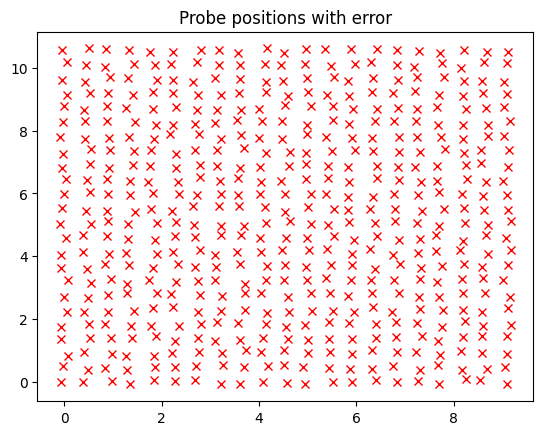

In [ ]:
fix, ax = plt.subplots()
ax.plot(scan_pos_flat_error[:, 0], scan_pos_flat_error[:, 1], 'rx')
ax.set_title("Probe positions with error");

Generate some new diffraction patterns using the new probe positions:

In [ ]:
abtem_patterns_error = (
    probe.scan(
        potential,
        scan=abtem.CustomScan(scan_pos_flat_error),
        detectors=detector,
    )
    .compute()
    .array
)
abtem_patterns_error.shape

[                                        ] | 0% Completed | 403.07 us

[########################################] | 100% Completed | 206.34 ms


(504, 48, 56)

To optimise probe positions we need a new loss function which takes the error in the scan position:

In [ ]:
def loss_with_probe_error(
    abtem_patterns, transmit, probe_fft, scan_positions, scan_position_error, prop_kernel, shift_frequencies
):
    jax_patterns, _ = simulate_pattern_shifting_jit(
        transmit,
        probe_fft,
        scan_positions + scan_position_error,
        prop_kernel,
        shift_frequencies,
    )
    return (
        jnp.mean(
            optax.l2_loss(jax_patterns, abtem_patterns)
        )
    )

loss_with_probe_error_jit = jax.jit(loss_with_probe_error)

In [ ]:
opt_scan_error = jnp.zeros_like(scan_pos_flat_error)
scan_error_learning_rate = 1e0
optimizer_scan_error = optax.adam(scan_error_learning_rate)
opt_state_scan_error = optimizer_scan_error.init(opt_scan_error)

To begin we will just optimise the errors, using the correct object and probe:

In [ ]:
chunksize = 256
chunks = tuple(
    slice(ix, min(ix + chunksize, num_patterns))
    for ix in range(0, num_patterns, chunksize)
)

val_and_grad_scan_error = jax.value_and_grad(loss_with_probe_error_jit, argnums=4)

probe_fft = jnp.fft.fft2(all_probes_flat[0])
grads_scan_errors_full = np.zeros_like(
    scan_pos_flat_error
)

for epoch in (outer_pbar := tqdm.trange(500)):
    np.random.shuffle(iteration_idxs)
    for chunk in chunks:
        loss_val, grads_scan_errors = val_and_grad_scan_error(
            abtem_patterns_error[iteration_idxs[chunk]],
            transmit,
            probe_fft,
            scan_pos_flat[iteration_idxs[chunk]],
            opt_scan_error[iteration_idxs[chunk]],
            prop_abtem,
            shift_frequencies,
        )
        # this is a bit of a hack, there is certainly a way to do masked updates with Optax
        grads_scan_errors_full[:] = 0.
        grads_scan_errors_full[iteration_idxs[chunk]] = grads_scan_errors
        updates_scan_error, opt_state_scan_error = optimizer_scan_error.update(
            jnp.asarray(grads_scan_errors_full),
            opt_state_scan_error,
        )
        opt_scan_error = optax.apply_updates(
            opt_scan_error,
            updates_scan_error,
        )
        outer_pbar.set_description(f"Loss {loss_val: .3e}")

  0%|          | 0/500 [00:00<?, ?it/s]

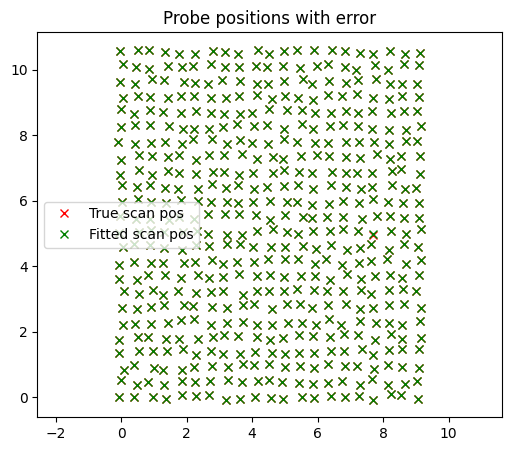

In [ ]:
opt_scan_pos = scan_pos_flat + opt_scan_error
fix, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1.plot(scan_pos_flat_error[:, 0], scan_pos_flat_error[:, 1], 'rx', label="True scan pos")
# ax1.set_title("True probe positions with error")
ax1.plot(opt_scan_pos[:, 0], opt_scan_pos[:, 1], 'gx', label="Fitted scan pos")
ax1.set_title("Probe positions with error")
ax1.legend()
ax1.axis('equal');

You can see how we would be able to introduce this into the above object + probe reconstruction, as part of the training schedule.

## Limitations and further extensions

This approach is very flexible, simple and understandable, but on most (real) data will not have great convergence properties.

It is, however, extensible - it would be trivial to add multiple probe and object modes (just sum over multiple input arrays). Probe tilt can be added (up to small angles) by modifying the propagation kernel.

To improve convergence the loss function can be augmented to add penalisation terms, or regularisation. These would constrain the gradient space to objects and probes which are reasonable, structured, and scaled correctly. Similarly probe position error could be constrained to within a small distance of the intended position, so as to limit solutions which are infeasible.

In [ ]:
raise

RuntimeError: No active exception to reraise

## More realistic data

In [ ]:
abtem.config.set({"device": "gpu"});

In [ ]:
atoms = ase.build.mx2(vacuum=0.8)
atoms.set_cell(atoms.cell * np.asarray([1, 1, 3]), scale_atoms=True)
atoms = abtem.orthogonalize_cell(atoms)
depth = 16
mult = 10
atoms *= (3 * mult, 2 * mult, depth)

frozen_phonons = abtem.FrozenPhonons(
    atoms,
    num_configs=32,
    sigmas=0.1,
)
potential_phonon = abtem.Potential(
    frozen_phonons,
    sampling=base_sampling,
    slice_thickness=base_slice_thickness * depth,
)
potential_phonon.shape

(32, 3, 477, 551)

In [ ]:
aber_scaling = 10
probe_testing = abtem.Probe(
    energy=energy,
    semiangle_cutoff=20,
    defocus=defocus,
    Cs=Cs * aber_scaling,
    astigmatism=astigmatism * aber_scaling,
    astigmatism_angle=astigmatism_angle,
    trefoil=trefoil * aber_scaling,
    trefoil_angle=trefoil_angle,
    coma=coma * aber_scaling,
    coma_angle=coma_angle,
)
probe_testing.grid.match(potential_phonon)

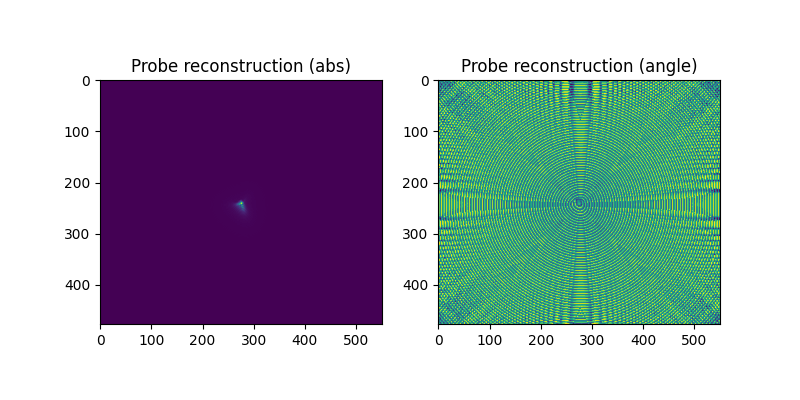

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(np.abs(probe_testing.build(lazy=False).to_cpu().array))
ax1.set_title('Probe reconstruction (abs)');
ax2.imshow(np.angle(probe_testing.build(lazy=False).to_cpu().array))
ax2.set_title('Probe reconstruction (angle)');

In [ ]:
grid_scan = abtem.GridScan(
    start=(0.2, 0.2),
    end=(0.8, 0.8),
    fractional=True,
    sampling=probe_testing.aperture.nyquist_sampling * 4,
    potential=potential_phonon,
)
scan_positions = np.array(grid_scan.get_positions())
grid_scan.shape

(58, 66)

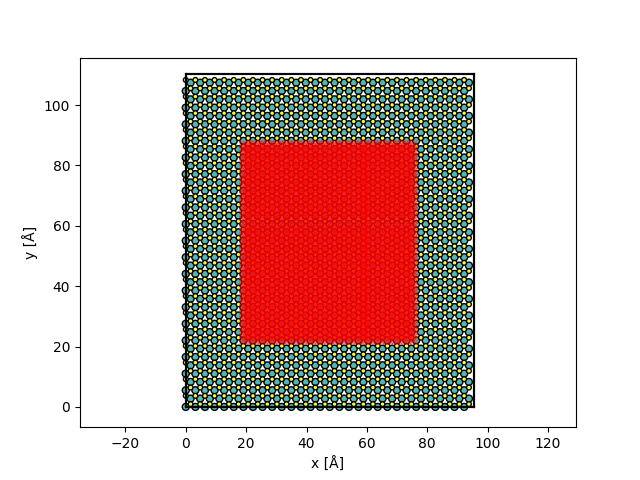

In [ ]:
fig, ax = abtem.show_atoms(atoms)
scan_pos_flat = scan_positions.reshape(-1, 2)
ax.plot(scan_pos_flat[:, 0], scan_pos_flat[:, 1], 'rx', alpha=0.5);

In [ ]:
measurements_phonon = probe_testing.scan(
    potential_phonon,
    scan=grid_scan,
    detectors=abtem.PixelatedDetector(max_angle='valid', to_cpu=False),
)
patterns_hr = (
    measurements_phonon
    .compute()
)

[########################################] | 100% Completed | 153.78 s


In [ ]:
import cupy as cp
patterns_noisy = cp.asarray(
    patterns_hr
    .gaussian_filter(0.01)
    .poisson_noise(total_dose=1e7)
    .array
)

patterns_noisy += cp.random.poisson(
    lam=2.0,
    size=patterns_noisy.shape
)
patterns_noisy_flat = patterns_noisy.reshape(-1, *patterns_noisy.shape[-2:])
patterns_fft = cp.fft.fft2(patterns_noisy_flat)
patterns_fft /= cp.linalg.norm(patterns_fft, axis=(-1, -2), keepdims=True)
patterns_noisy_flat = cp.fft.ifft2(patterns_fft).real
patterns_noisy_flat = patterns_noisy_flat.get()
patterns_noisy_flat.shape

(3828, 225, 259)

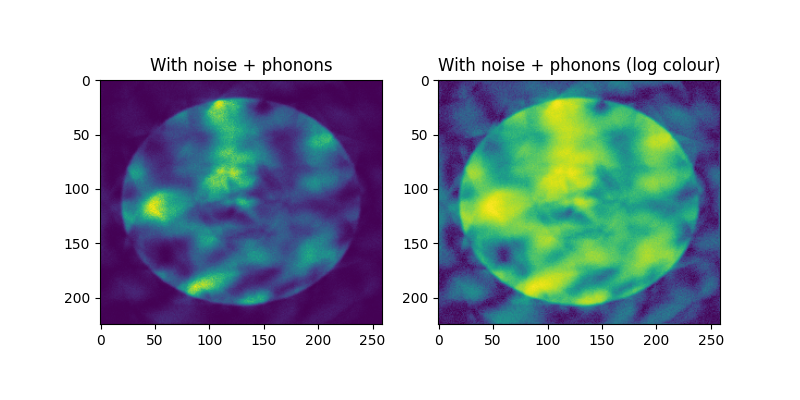

In [ ]:
import matplotlib.colors as colors
pattern_idx = 125
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
nb_pat = patterns_noisy_flat[pattern_idx]
ax1.imshow(
    nb_pat,
)
ax1.set_title("With noise + phonons");
ax2.imshow(
    nb_pat + 1e-6,
    norm=colors.LogNorm()
)
ax2.set_title("With noise + phonons (log colour)");